## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/facial-keypoints'

In [16]:
ls

 data/   example.png  'Facial keypoints.ipynb'   get_data.pyc


### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [15]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ImportError: ignored

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [30]:
### Useful routines for preparing data
import numpy as np
import pandas as pd
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='data'):
  #Loading images
  data = pd.read_csv(dirname+'/'+"gt.csv")
  N = data.shape[0]
  array_keypoints = np.array(data[data.columns[1:]].as_matrix(), dtype= np.float32)
  points = np.zeros_like(array_keypoints, dtype=np.float32)
  imgs = np.zeros((N, 100, 100, 3))
  
  #Scalling images
  for i in range(N):
    fname = imread(dirname +'/images/'+ data.filename[i])
    h = fname.shape[1]
    w = fname.shape[0]
    points[i,:] = array_keypoints[i,:]/np.tile([w, h], 14) - 0.5
    fname = resize(fname, (100, 100, 3))
    imgs[i,:,:,:] = fname
    
  return imgs, points

imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


array([-0.31862745, -0.27941176, -0.04901961, -0.29411766,  0.10294118,
       -0.27450982,  0.25      , -0.29411766, -0.25490198, -0.19117647,
       -0.16666667, -0.19607843, -0.09313726, -0.1764706 ,  0.09313726,
       -0.18627451,  0.16666667, -0.2009804 ,  0.21078432, -0.19117647,
        0.12254902,  0.02941176, -0.15686275,  0.16666667,  0.04901961,
        0.19117647,  0.13725491,  0.16666667], dtype=float32)

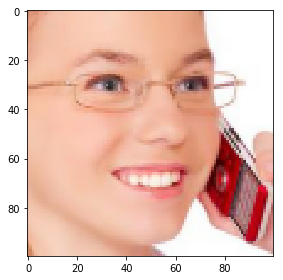

In [38]:
_# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[6])
points[6]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

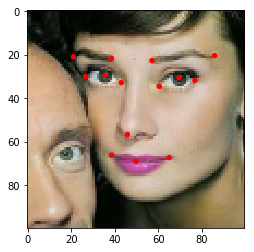

In [37]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig = plt.figure()
    axe = fig.add_subplot(1, 1, 1)
    plt.imshow(img)
    
    #Scaling points
    points_rec = np.clip(np.array((points+0.5)*100, dtype = np.float32), 0, 99)
    
    for i in range(14):
      xy = (points_rec[2*i], points_rec[2*i+1])
      C = Circle(xy, radius = 1, color = 'red')
      axe.add_patch(C)
      
visualize_points(imgs[5], points[5])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

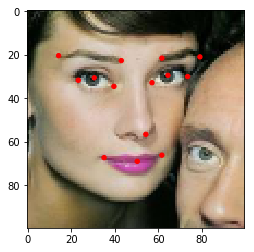

In [48]:
def flip_img(img, points):
    #Mirroring imgs 
    flipped_img = img[:,::-1,:]
    
    #Mirroring points
    flipped_keypoints = np.copy(points)
    
    for i in range(14):
      flipped_keypoints[2*i] = -points[2*i] 
    
    return flipped_img, flipped_keypoints
      
f_img, f_points = flip_img(imgs[5], points[5])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

Number of samples after augmenting dataset is:  5400


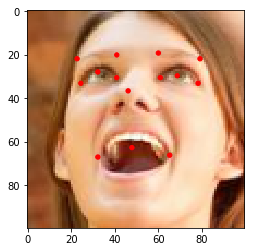

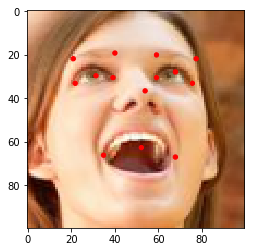

In [56]:
# Augmeting our dataset

m = imgs_train.shape[0]

aug_imgs_train = np.zeros((2*m, 100, 100, 3), dtype=np.float32)
aug_points_train = np.zeros((2*m, 28))

for i in range(m):
  aug_imgs_train[2*i] = imgs_train[i]
  aug_points_train[2*i] = points_train[i]
  
  flipped_img, flipped_point = flip_img(imgs_train[i], points_train[i])
  aug_imgs_train[2*i+1] = flipped_img
  aug_points_train[2*i+1] = flipped_point
  
print("Number of samples after augmenting dataset is: ", imgs_train.shape[0])
visualize_points(aug_imgs_train[4], aug_points_train[4])
visualize_points(aug_imgs_train[5], aug_points_train[5])


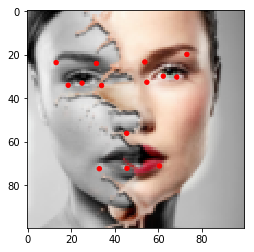

In [57]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

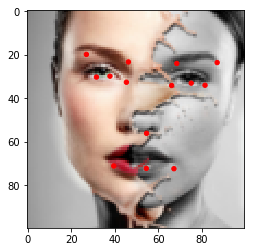

In [58]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [59]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
# Define here your model
model.add(Conv2D(filters =32, kernel_size = (3,3) , padding='valid', activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(filters =32, kernel_size = (3,3) , padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters =64, kernel_size = (3,3) , padding='valid', activation='relu'))
model.add(Conv2D(filters =64, kernel_size = (3,3) , padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters =128, kernel_size = (3,3) , padding='valid', activation='relu'))
model.add(Conv2D(filters =128, kernel_size = (3,3) , padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
     
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=28, activation=None))
model.summary()          

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxP

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [61]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(aug_imgs_train, aug_points_train, batch_size=128, shuffle=True, epochs=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10800/10800 [==============================] - 632s 59ms/step - loss: 0.0230 - acc: 0.0294


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[50.056    24.181684 50.00763  23.294767 49.567017 22.964338 49.96239
 22.511635 50.264584 31.519184 49.656494 31.901794 50.06773  32.002426
 49.744152 32.476162 50.3951   30.537914 49.74354  30.591785 50.622272
 52.66164  49.969284 68.65656  50.12006  67.80769  50.711597 68.109955]


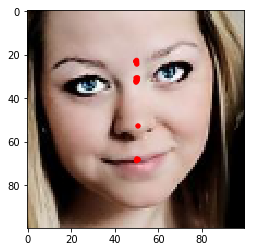

In [64]:
i = 20
img = imgs_val[i:i+1]
img_points = points_val[i:i+1]
pred_points = model.predict(img)[0]
visualize_points(img[0], pred_points)
print((pred_points+0.5)*100)